In [1]:
import squigglepy as sq
import numpy as np

from datetime import datetime
from pprint import pprint

from libs import run_model, samples_to_date, calculate_doubling_time, plot_exponential_growth


O3_LAUNCH_DATE = datetime(2025, 4, 16)
CLAUDE_3P7_LAUNCH_DATE = datetime(2025, 2, 24)

print('Loaded libraries')

Loaded libraries


In [2]:
def metr_model():
    days = calculate_doubling_time(start_task_length=1, agi_task_length=167, doubling_time=212, acceleration=1) # Variables from METR paper
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add easurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model, index_date=CLAUDE_3P7_LAUNCH_DATE) # Results should look similar to Figure 12

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12718.40it/s]


{1: 1101,
 5: 1255,
 10: 1344,
 20: 1461,
 30: 1552,
 40: 1633,
 50: 1715,
 60: 1800,
 70: 1894,
 80: 2012,
 90: 2190,
 95: 2349,
 99: 2666}

-

{1: '2028 Mar 02',
 5: '2028 Aug 02',
 10: '2028 Oct 31',
 20: '2029 Feb 25',
 30: '2029 May 27',
 40: '2029 Aug 16',
 50: '2029 Nov 06',
 60: '2030 Jan 29',
 70: '2030 May 04',
 80: '2030 Aug 30',
 90: '2031 Feb 24',
 95: '2031 Aug 01',
 99: '2032 Jun 13'}


In [3]:
def metr_model_with_o3():
    days = calculate_doubling_time(start_task_length=1.75, agi_task_length=167, doubling_time=118, acceleration=1) # Use o3 task length, o3 launch date, and the 2024-2025 doubling time
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

_ = run_model(metr_model_with_o3, index_date=O3_LAUNCH_DATE)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:07<00:00, 12638.60it/s]


{1: 544,
 5: 622,
 10: 666,
 20: 724,
 30: 769,
 40: 810,
 50: 851,
 60: 892,
 70: 939,
 80: 998,
 90: 1086,
 95: 1164,
 99: 1324}

-

{1: '2026 Oct 12',
 5: '2026 Dec 29',
 10: '2027 Feb 11',
 20: '2027 Apr 10',
 30: '2027 May 26',
 40: '2027 Jul 05',
 50: '2027 Aug 15',
 60: '2027 Sep 26',
 70: '2027 Nov 12',
 80: '2028 Jan 09',
 90: '2028 Apr 07',
 95: '2028 Jun 24',
 99: '2028 Dec 01'}


In [4]:
# The simpler model with static variables from my Substack
def simple_model():
    days = calculate_doubling_time(start_task_length=3.75/60, agi_task_length=167, doubling_time=165, acceleration=1)
    shift = 100
    return days - shift

_ = run_model(simple_model, index_date=O3_LAUNCH_DATE)

100%|██████████████████████████████████████████████████████████████████████████| 100000/100000 [00:04<00:00, 20752.95it/s]


{1: 1778,
 5: 1778,
 10: 1778,
 20: 1778,
 30: 1778,
 40: 1778,
 50: 1778,
 60: 1778,
 70: 1778,
 80: 1778,
 90: 1778,
 95: 1778,
 99: 1778}

-

{1: '2030 Feb 28',
 5: '2030 Feb 28',
 10: '2030 Feb 28',
 20: '2030 Feb 28',
 30: '2030 Feb 28',
 40: '2030 Feb 28',
 50: '2030 Feb 28',
 60: '2030 Feb 28',
 70: '2030 Feb 28',
 80: '2030 Feb 28',
 90: '2030 Feb 28',
 95: '2030 Feb 28',
 99: '2030 Feb 28'}


In [5]:
print('## START task length (displayed in min) ##')

# -- DEFINE CURRENT BEST
current_best = 1.75 # o3 task length at 50% reliability?

# -- DEFINE ADJUSTMENTS
elicitation_boost = sq.mixture([[0.3, 1], # Can you get a boost to scores by iterating on scaffolding and other elicitation techniques? 30% chance no, 40% chance you can get a 1.2x speed up, 30% chance of 1.5x.
                                [0.4, 1.2],
                                [0.3, 1.5]])

inference_compute_adj = sq.lognorm(lognorm_mean=2, lognorm_sd=1, lclip=1) # Can you get a boost to scores by increasing inference compute to human level? Approx doubling
                               
reliability_needed = sq.mixture([[0.2, 0.5], # What amount of reliability will we need? Probability distribution over hypotheses
                                 [0.4, 0.8],
                                 [0.2, 0.9],
                                 [0.1, 0.95],
                                 [0.1, 0.99]])

def reliability_count_to_penalty(reliability):
    r = np.asarray(reliability, dtype=float)
    reliability = np.array([0.50, 0.80, 0.90, 0.95, 0.99])
    penalty = np.array([1.0, 0.25, 0.25**2, 0.25**3, 0.25**4])
    matches = r[..., None] == reliability
    hit_any = matches.any(axis=-1)
    idx = matches.argmax(axis=-1)
    out = np.full_like(r, np.nan, dtype=float)
    out[hit_any] = penalty[idx[hit_any]]
    return out

task_type_penalty = sq.mixture([[0.1, 1],                         # 10% chance that METR's software tasks are sufficient for AGI
                                [0.3, 1 / sq.lognorm(5, 20)],     # 30% chance that true AGI tasks are 5-20x harder than METR's software tasks
                                [0.6, 1 / sq.lognorm(10, 1000)]]) # 60% chance that true AGI tasks are 10-1000x harder than METR's software tasks

# -- CREATE DISTRIBUTION
# Start with current best, add elicitation boost
start_task_length = current_best * elicitation_boost

# add inference compute adjustment
start_task_length = start_task_length * inference_compute_adj

# add reliability penalty
start_task_length = start_task_length * sq.dist_fn(reliability_needed, reliability_count_to_penalty)

# Add task type penalty
start_task_length *= task_type_penalty

# Add a minimum value of 1sec
start_task_length = sq.dist_max(1/60/60, start_task_length)

# Show samples in minutes (naturally in hours)
sq.get_percentiles((start_task_length * 60) @ 100_000, digits=2)

## START task length (displayed in min) ##


{1: 0.02,
 5: 0.02,
 10: 0.03,
 20: 0.1,
 30: 0.25,
 40: 0.52,
 50: 1.03,
 60: 2.02,
 70: 4.03,
 80: 8.41,
 90: 24.41,
 95: 54.3,
 99: 236.33}

In [6]:
print('## AGI task length (displayed in hrs) ##')
agi_task_length = sq.lognorm(80, 2000, credibility=80, lclip=40)
sq.get_percentiles(agi_task_length @ 100_000, digits=0)

## AGI task length (displayed in hrs) ##


{1: 40,
 5: 51,
 10: 80,
 20: 139,
 30: 207,
 40: 289,
 50: 399,
 60: 547,
 70: 769,
 80: 1141,
 90: 1999,
 95: 3157,
 99: 7481}

In [7]:
print('## DOUBLING TIME (displayed in days) ##')
doubling_time = sq.mixture([[0.3, 212],
                            [0.1, 118],
                            [0.6, sq.lognorm(lognorm_mean=185.25, lognorm_sd=40)]])
sq.get_percentiles(doubling_time @ 100_000, digits=0)

## DOUBLING TIME (displayed in days) ##


{1: 115,
 5: 118,
 10: 118,
 20: 147,
 30: 165,
 40: 181,
 50: 199,
 60: 212,
 70: 212,
 80: 212,
 90: 223,
 95: 243,
 99: 286}

In [8]:
print('## ACCELERATION (displayed in days)')
acceleration = sq.mixture([[0.1, 1 + sq.lognorm(0.005, 0.1, credibility=80)],
                           [0.8, 1],
                           [0.1, 1 - sq.lognorm(0.005, 0.1, credibility=80)]])
sq.get_percentiles(acceleration @ 100_000, digits=3)

## ACCELERATION (displayed in days)


{1: 0.901,
 5: 0.978,
 10: 0.998,
 20: 1.0,
 30: 1.0,
 40: 1.0,
 50: 1.0,
 60: 1.0,
 70: 1.0,
 80: 1.0,
 90: 1.0,
 95: 1.022,
 99: 1.098}

In [9]:
print('## SHIFT (displayed in days) ##')
shift = sq.norm(30, 30*5, credibility=80, lclip=0)
sq.get_percentiles(shift @ 100_000, digits=0)

## SHIFT (displayed in days) ##


{1: 0,
 5: 13,
 10: 30,
 20: 51,
 30: 66,
 40: 79,
 50: 90,
 60: 102,
 70: 115,
 80: 130,
 90: 150,
 95: 167,
 99: 200}

In [10]:
def adapted_metr_model():
    start_task_length_ = start_task_length * (2 ** (shift / doubling_time))
    days = calculate_doubling_time(start_task_length_, agi_task_length, doubling_time, acceleration)
    measurement_error_variance = sq.invlognorm(0.8, 1.5) # Add measurement error on tasks: SD fit to trend variance from Figure 12
    return days * measurement_error_variance

samples = run_model(adapted_metr_model, index_date=O3_LAUNCH_DATE)

100%|███████████████████████████████████████████████████████████████████████████| 100000/100000 [01:19<00:00, 1253.56it/s]


{1: 851,
 5: 1256,
 10: 1520,
 20: 1888,
 30: 2193,
 40: 2481,
 50: 2773,
 60: 3089,
 70: 3447,
 80: 3890,
 90: 4554,
 95: 5147,
 99: 6374}

-

{1: '2027 Aug 15',
 5: '2028 Sep 24',
 10: '2029 Jun 15',
 20: '2030 Jun 18',
 30: '2031 Apr 19',
 40: '2032 Jan 31',
 50: '2032 Nov 18',
 60: '2033 Oct 01',
 70: '2034 Sep 23',
 80: '2035 Dec 11',
 90: '2037 Oct 05',
 95: '2039 May 21',
 99: '2042 Sep 29'}


In [11]:
print('## DISTRIBUTION OF AGI ARRIVAL DATE ##')
# Convert datetime samples to years
agi_years = [s / 365 + 2025 for s in samples]
pctiles = sq.get_percentiles(agi_years, percentiles=[1, 2, 3, 4, 5, 10, 15, 20, 25, 35, 50, 60, 75, 80, 90, 95])
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1], 1))) if o[1] < 2100 else '>2100') 
    for o in pctiles.items()
])
print('')
print('')
print('## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##')
pprint([
    ((str(o[0]) + '%: ' + str(round(o[1] - 2025, 1))) if o[1] < 2100 else '>75') + ' years from now' 
    for o in pctiles.items()
])
print('(Mean: {} years from now)'.format(int(round(np.mean([t - 2025 for t in agi_years])))))
print('')
print('')


print('## AGI ARRIVAL DATE BY BIN ##')

def bin_agi_yrs(low=None, hi=None):
    low = 2025 if low is None else low
    if hi is None:
        r = np.mean([y >= low for y in agi_years])
    else:
        r = np.mean([(y >= low) and (y <= hi) for y in agi_years])
    return round(r * 100, 1)


year_pairs = [[2025, 2026],
              [2026, 2027],
              [2027, 2028],
              [2028, 2029],
              [2029, 2030],
              [2030, 2032],
              [2032, 2035],
              [2035, 2040],
              [2040, 2050],
              [2050, 2060],
              [2060, 2070],
              [2070, 2080],
              [2080, 2090],
              [2090, 2100]]
for y in year_pairs:
    if y[0] == y[1] - 1:
        print('{}: {}%'.format(y[0], bin_agi_yrs(y[0], y[1])))
    else:
        print('{}-{}: {}%'.format(y[0], y[1]-1, bin_agi_yrs(y[0], y[1])))
print('>{}: {}%'.format(2100, bin_agi_yrs(low=2100)))
print('')
print('')

print('## AGI ARRIVAL DATE BY YEAR ##')
for y in list(range(2025, 2035)) + list(range(2035, 2100, 5)):
    print('By EOY {}: {}%'.format(y, bin_agi_yrs(hi=y+1)))
print('')

## DISTRIBUTION OF AGI ARRIVAL DATE ##
['1%: 2027.3',
 '2%: 2027.7',
 '3%: 2028.0',
 '4%: 2028.3',
 '5%: 2028.4',
 '10%: 2029.2',
 '15%: 2029.7',
 '20%: 2030.2',
 '25%: 2030.6',
 '35%: 2031.4',
 '50%: 2032.6',
 '60%: 2033.5',
 '75%: 2035.0',
 '80%: 2035.7',
 '90%: 2037.5',
 '95%: 2039.1']


## DISTRIBUTION OF RELATIVE AGI ARRIVAL DATE ##
['1%: 2.3 years from now',
 '2%: 2.7 years from now',
 '3%: 3.0 years from now',
 '4%: 3.3 years from now',
 '5%: 3.4 years from now',
 '10%: 4.2 years from now',
 '15%: 4.7 years from now',
 '20%: 5.2 years from now',
 '25%: 5.6 years from now',
 '35%: 6.4 years from now',
 '50%: 7.6 years from now',
 '60%: 8.5 years from now',
 '75%: 10.0 years from now',
 '80%: 10.7 years from now',
 '90%: 12.5 years from now',
 '95%: 14.1 years from now']
(Mean: 8 years from now)


## AGI ARRIVAL DATE BY BIN ##
2025: 0.0%
2026: 0.5%
2027: 2.3%
2028: 5.8%
2029: 9.4%
2030-2031: 24.5%
2032-2034: 32.3%
2035-2039: 21.8%
2040-2049: 3.2%
2050-2059: 0.0%
2060-2069: 0.0%
20

## Overall prediction

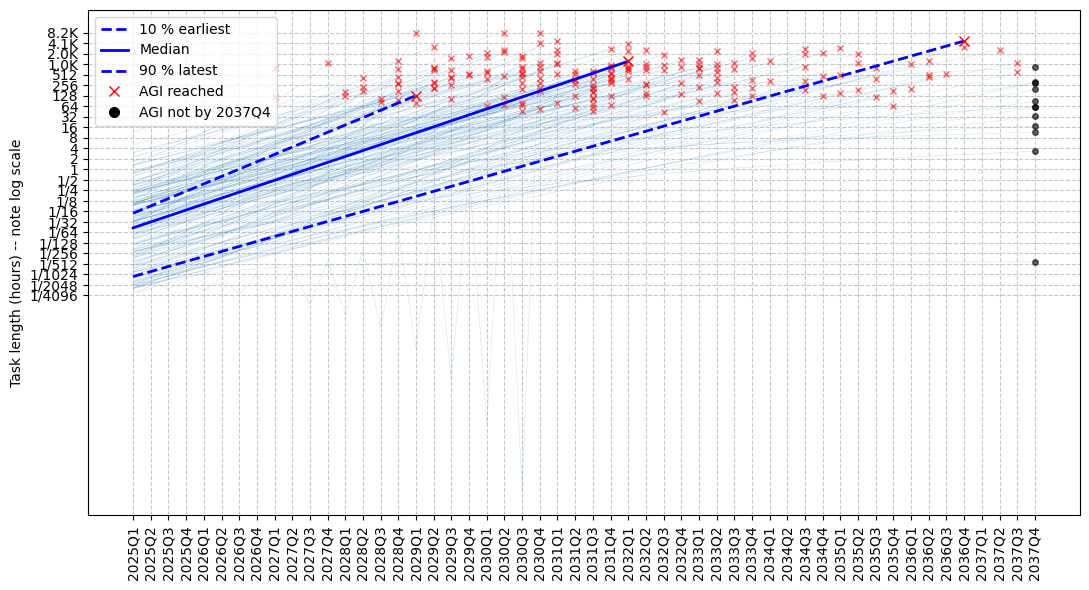

In [12]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=start_task_length,
    agi_task_length=agi_task_length,
    shift=shift,
    acceleration=acceleration,
    n_quarters=51,
    n_samples=100_000,
    n_traces=200,
    max_task_power=13,
    min_y_power=-15,
)

## Project next METR

In [13]:
# Generate quarterly METR predictions (PUBLIC MODELS - NO SHIFT)
print("METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS")
print("=" * 70)
print(f"Baseline: o3 at 1.75hr on {O3_LAUNCH_DATE.strftime('%Y-%m-%d')}")
print("=" * 70)
print()

# Define quarters to predict (END of quarter)
def end_of_quarter(year, q):
    if q == 1:
        return datetime(year, 3, 31)
    elif q == 2:
        return datetime(year, 6, 30)
    elif q == 3:
        return datetime(year, 9, 30)
    else:  # q == 4
        return datetime(year, 12, 31)

quarters = []
# Start with Q2 2025 since o3 launched in April
for year in range(2025, 2030):
    start_q = 2 if year == 2025 else 1
    for q in range(start_q, 5):
        quarters.append((year, q, end_of_quarter(year, q)))

# Sample parameters
n_samples = 50000
tau_samples = sq.sample(doubling_time, n=n_samples)
accel_samples = sq.sample(acceleration, n=n_samples)

print(f"{'Quarter':<8} {'End Date':<12} {'Mean':<10} {'Median':<10} {'90% CI':<25} {'Days'}")
print("-" * 85)

results = []
for year, q, quarter_date in quarters:
    days_from_o3 = (quarter_date - O3_LAUNCH_DATE).days
    
    if days_from_o3 < 0:
        continue
    
    # Calculate task length for each sample
    # NO SHIFT for public models
    effective_days = days_from_o3  # Changed: removed + shift_samples
    
    # Use the calculate_doubling_time function logic
    task_lengths = np.zeros(n_samples)
    for i in range(n_samples):
        if accel_samples[i] == 1:
            # Simple exponential
            doublings = effective_days / tau_samples[i]
            task_lengths[i] = 1.75 * (2 ** doublings)
        else:
            # Superexponential - use binary search
            low, high = 0, 100
            target_days = effective_days
            tau0 = tau_samples[i]
            a = accel_samples[i]
            
            for _ in range(50):
                mid = (low + high) / 2
                predicted_days = tau0 * (1 - a**mid) / (1 - a) if a != 1 and a > 0 and not np.isnan(a) else mid * tau0
                
                if predicted_days < target_days:
                    low = mid
                else:
                    high = mid
            
            doublings = (low + high) / 2
            task_lengths[i] = 1.75 * (2 ** doublings)
    
    # Cap at reasonable maximum
    task_lengths = np.minimum(task_lengths, 2000)
    
    # Calculate statistics
    mean_val = np.mean(task_lengths)
    median_val = np.median(task_lengths)
    p5 = np.percentile(task_lengths, 5)
    p95 = np.percentile(task_lengths, 95)
    
    def fmt_time(hrs):
        # Using work time: 8hr/day, 40hr/week
        if hrs < 1:
            return f"{int(hrs * 60)}min"
        elif hrs < 8:
            return f"{hrs:.1f}hr"
        elif hrs < 40:
            return f"{hrs/8:.1f}d"
        else:
            return f"{hrs/40:.1f}wk"
    
    ci_str = f"[{fmt_time(p5)} - {fmt_time(p95)}]"
    date_str = quarter_date.strftime("%Y-%m-%d")
    
    print(f"{year}Q{q:<7} {date_str:<12} {fmt_time(mean_val):<10} {fmt_time(median_val):<10} {ci_str:<25} {days_from_o3:>4}")
    
    results.append({
        'quarter': f"{year}Q{q}",
        'date': quarter_date,
        'mean': mean_val,
        'median': median_val,
        'p5': p5,
        'p95': p95,
        'days': days_from_o3,
        'task_lengths': task_lengths
    })
    
    if q == 4:
        print()

# Show key milestones
print("\n" + "=" * 70)
print("Key Milestones (Median Estimates) - PUBLIC MODELS")
print("=" * 70)

# Updated milestones using work time
milestones = [(2, "2 hours"), (4, "4 hours"), (8, "1 day"), 
              (16, "2 days"), (24, "3 days"), (40, "1 week"), (174, "1 month")]

for hours, name in milestones:
    for r in results:
        if r['median'] >= hours:
            prob = np.mean(r['task_lengths'] >= hours) * 100
            date_str = r['date'].strftime("%B %d, %Y")
            print(f"{name:<12} → {r['quarter']} ({date_str}, {prob:.0f}% of samples)")
            break
    else:
        print(f"{name:<12} → Not reached by 2029Q4")

METR Task Horizon Predictions (50% reliability) - PUBLIC MODELS
Baseline: o3 at 1.75hr on 2025-04-16

Quarter  End Date     Mean       Median     90% CI                    Days
-------------------------------------------------------------------------------------
2025Q2       2025-06-30   2.4hr      2.3hr      [2.2hr - 2.7hr]             75
2025Q3       2025-09-30   3.4hr      3.1hr      [2.8hr - 4.7hr]            167
2025Q4       2025-12-31   5.2hr      4.3hr      [3.7hr - 1.0d]             259

2026Q1       2026-03-31   1.0d       5.9hr      [4.7hr - 1.7d]             349
2026Q2       2026-06-30   1.5d       1.0d       [6.1hr - 2.9d]             440
2026Q3       2026-09-30   2.3d       1.4d       [7.9hr - 5.0d]             532
2026Q4       2026-12-31   3.7d       2.0d       [1.3d - 1.7wk]             624

2027Q1       2027-03-31   1.1wk      2.7d       [1.6d - 2.9wk]             714
2027Q2       2027-06-30   1.7wk      3.7d       [2.1d - 5.0wk]             805
2027Q3       2027-09-30 

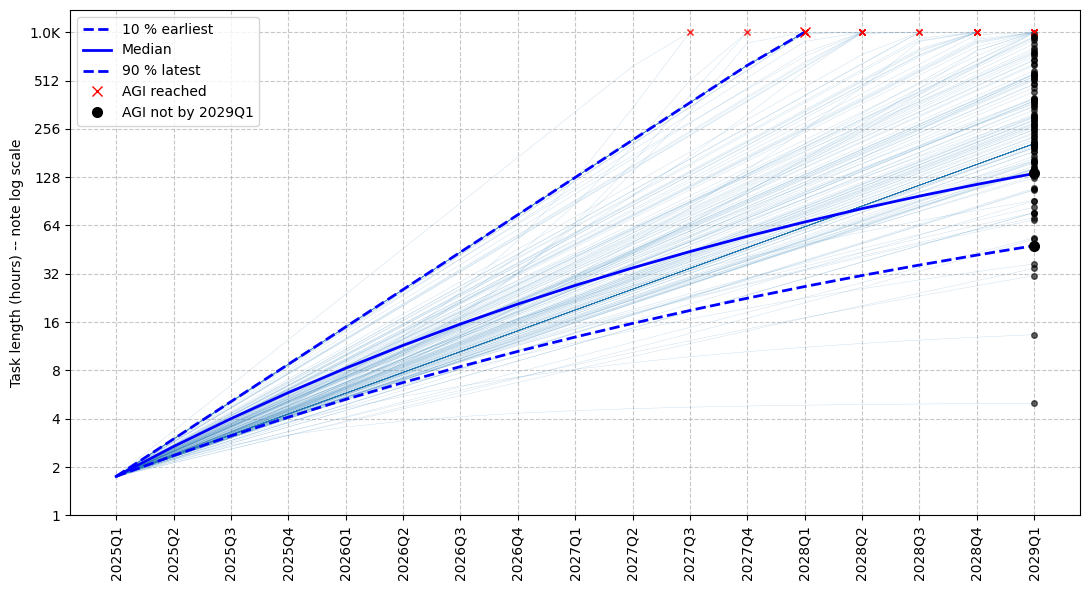

In [14]:
plot_exponential_growth(
    doubling_time_days=doubling_time,
    starting_hours=1.75,
    agi_task_length=100_000,
    shift=0,
    acceleration=acceleration,
    n_quarters=16,
    n_samples=100_000,
    n_traces=200,
    max_task_power=10,
)

In [15]:
# Sanity check WITH SHIFT=0 for public models
print("\n" + "=" * 70)
print("Sanity Check - Current State")
print("=" * 70)
today = datetime(2025, 7, 1)
days_since_o3 = (today - O3_LAUNCH_DATE).days
print(f"Days since o3: {days_since_o3}")
print(f"Model predictions for PUBLIC models on July 1, 2025:\n")
# Calculate for today WITH NO SHIFT
task_lengths_today_public = np.zeros(n_samples)
for i in range(n_samples):
    if accel_samples[i] == 1:
        doublings = days_since_o3 / tau_samples[i]
        task_lengths_today_public[i] = 1.75 * (2 ** doublings)
    else:
        # Binary search for doublings
        low, high = 0, 100
        target_days = days_since_o3  # NO SHIFT
        tau0 = tau_samples[i]
        a = accel_samples[i]
        
        for _ in range(50):
            mid = (low + high) / 2
            predicted_days = tau0 * (1 - a**mid) / (1 - a) if a != 1 and a > 0 and not np.isnan(a) else mid * tau0
            if predicted_days < target_days:
                low = mid
            else:
                high = mid
        
        doublings = (low + high) / 2
        task_lengths_today_public[i] = 1.75 * (2 ** doublings)
task_lengths_today_public = np.minimum(task_lengths_today_public, 2000)

# Format the outputs using work time
p5_val = np.percentile(task_lengths_today_public, 5)
median_val = np.median(task_lengths_today_public)
mean_val = np.mean(task_lengths_today_public)
p95_val = np.percentile(task_lengths_today_public, 95)

print(f"5th percentile:  {fmt_time(p5_val)}")
print(f"Median:          {fmt_time(median_val)}")
print(f"Mean:            {fmt_time(mean_val)}")
print(f"95th percentile: {fmt_time(p95_val)}")
print(f"\nActual observed: Claude 4 at ~1.1-1.3 hours")
print(f"\nGap: {fmt_time(median_val)} predicted vs ~1.2hr actual")


Sanity Check - Current State
Days since o3: 76
Model predictions for PUBLIC models on July 1, 2025:

5th percentile:  2.2hr
Median:          2.3hr
Mean:            2.4hr
95th percentile: 2.7hr

Actual observed: Claude 4 at ~1.1-1.3 hours

Gap: 2.3hr predicted vs ~1.2hr actual
